**OBS:** debido a que github esta teniendo errores a la hora de visualizar notebooks que contengan palabras con acentos y con "enies" estas seran reemplazadas por su palabra en ingles o sin acentos.

ejm: 

años = years.

función = funcion.

# LIBRERIAS Y DATASET.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2_contingency, ttest_ind, t

In [ ]:
# cargamos desde nuestro disco el dataframe que iremos a analizar
from google.colab import files
uploaded = files.upload()

Saving Human_Resources.csv to Human_Resources.csv


In [ ]:
df = pd.read_csv("Human_Resources.csv")

Vemos la columna y el tipo de dato de c/u:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

**OBS:** Hacemos una division de los datos. Esto lo hacemos, ya que para analizar datos siempre es buena practica hacerlo sobre el conjunto de entrenamiento, que sera con el que nuestro modelo de ML sera entrenado.

Si analizamos tmb el conjunto de prueba podriamos generar algun tipo de overfitting y obviamente no queremos eso en nuestros resultados.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df,
                                                    df["Attrition"],
                                                    train_size = 0.7,
                                                    random_state= 0)

In [ ]:
X_train.shape, X_test.shape 

((1029, 35), (441, 35))

# FUNCIONES AUXILIARES.

## Funciones para el encoding de variables categoricas.

```python
def ordinal_encoding(X_train, X_test, features):
def counting_encoding(X_train, X_test, features):
def ordered_integer_encoding(X_train, X_test, features, target):
def probability_ratio_encoding(X_train, X_test, features, target):
```

In [ ]:
# codifica cada valor unico en un feature con un entero unico
def ordinal_encoding(X_train, X_test, features):
  X_train_r = X_train.copy()
  X_test_r = X_test.copy()

  for feature in features:

    # creo diccionario con un numero que representa cada valor unico
    ordinal_mapping = {k:i for i,k in enumerate(X_train[feature].unique(),0)}

    X_train_r[feature] = X_train_r[feature].map(ordinal_mapping)
    X_test_r[feature] = X_test_r[feature].map(ordinal_mapping)

  return X_train_r, X_test_r

# codifica cada valor unico en un feature con su debido numero de ocurrencias
def counting_encoding(X_train, X_test, features):
  X_train_r = X_train.copy()
  X_test_r = X_test.copy()

  for feature in features:

    # creo diccionario con la suma de las ocurrencias de cada valor
    ordinal_mapping = X_train[feature].value_counts().to_dict()

    # reemplazo los valores categoricos por su ctdad de ocurrencias
    X_train_r[feature] = X_train_r[feature].map(ordinal_mapping)
    X_test_r[feature] = X_test_r[feature].map(ordinal_mapping)
  
  return X_train_r, X_test_r


# codifica cada valor unico en un feature con un entero
# si el target de acuerdo a un label en particular presenta
# una media mas elevada => dicho label obtendra un valor de entero mayor
# que otro label que tenga dicha media mas reducida.
def ordered_integer_encoding(X_train, X_test, features, target):
  X_train_r = X_train.copy()
  X_test_r = X_test.copy()

  for feature in features:

    # agrupo por feature y calculo la media del target y ordeno de forma ascendente
    ordered_labels = X_train_r.groupby(by=feature)[target].mean().sort_values().index

    # creo el diccionario indicando la media de los distintos labels per feature
    ordinal_mapping = {k:i for i,k in enumerate(ordered_labels, 0)}

    X_train_r[feature] = X_train_r[feature].map(ordinal_mapping)
    X_test_r[feature] = X_test_r[feature].map(ordinal_mapping)

  return X_train_r, X_test_r


# codifica cada valor unico en un feature con su debido radio
def probability_ratio_encoding(X_train, X_test, features, target):
  X_train_r = X_train.copy()
  X_test_r = X_test.copy()

  for feature in features:

    # agrupo por feature y calculo la media del target
    tmp = pd.DataFrame(X_train_r.groupby(feature)[target].mean())
    
    # calculo el complemento de tmp
    tmp["no-target"] = 1 - tmp[target]

    # calculo el radio
    tmp["ratio"] = tmp[target] / tmp["no-target"]
    
    ordinal_mapping = tmp["ratio"].to_dict()

    # reemplazo los valores categoricos por su radio respec
    X_train_r[feature] = X_train[feature].map(ordinal_mapping)
    X_test_r[feature] = X_test[feature].map(ordinal_mapping)

  return (X_train_r, X_test_r)

## Funciones para feature selection.

```python
def is_qsiconstant_feature(df, feature, treshold):
def method_1(df, limit):
```

In [ ]:
# calcula dado un feature, si este posee un valor constante de acuerdo a un limite dado
def is_qsiconstant_feature(df, feature, treshold):

  # calculo la frecuencia de los distintos valores en el feature
  diff_values_in_feature = df[feature].value_counts(normalize=True)

  # obtengo el valor que aparezca un porcentaje mayor al limite dado
  max_frecuent = diff_values_in_feature.values[0]

  # checkeo su freq con el limite
  if max_frecuent > treshold:
    return (diff_values_in_feature.index[0],max_frecuent)

  return "no hay labels con frecuencia mayor al limite dado"


# calcula features que tengan un nivel de correlacion mayor al limite dado
def method_1(df, limit):

  # guardamos los nombres de las columnas correlacionadas
  col_corr = []
  corr = df.corr(method='pearson')

  for i in range(len(corr.index)):
    
    col_1 = corr[corr.columns[i]].index[i]

    # este limite nos asegura recorrer solo la matriz triangular inferior
    # ya que si consideramos toda la matriz estariamos considerando valores ya comparados.
    for j in range(i):

      col_2 = corr[corr.columns[j]].index[j]
      corr_value = abs(corr[col_1].loc[[col_2]][0])

      if corr_value > limit:

        # no considero la correlacion de un feature consigo mismo
        if col_2 != col_1:

          # guardo en nuestra variable de columnas de correlaciones una 3-upla
          # el valor de la correlacion y las columnas involucradas
          col_corr.append((corr_value, col_1, col_2))

  return col_corr

## Otras funciones.

```python
def dict_of_cardinalities(df, features):
def group_rare_labels(X_train, X_test, feature, treshold):
```

In [ ]:
# calcula la cardinalidad para los features dados
# devuelve un diccionario de 2-uplas
# la primer upla indica la cardinalidad
# la segunda upla indica el porcentaje de c/valor de dicho feature
def dict_of_cardinalities(df, features):
  dict_card = {}

  for feature in features:

    cardinality = df[feature].nunique()
    dict_card[feature] = cardinality , df[feature].value_counts(normalize=True)

  return dict_card

# calcula la frecuencia de valores de un feature dado
# si la frecuencia de algun valor es menor al limite dado
# reemplaza dichos valores por el str Rare
def group_rare_labels(X_train, X_test, feature, treshold):

  X_train_r = X_train.copy()
  X_test_r =  X_test.copy()

  # calculo los porcentajes de valores de los labels de un feature
  perc_of_label = X_train_r[feature].value_counts(normalize=True)
  
  # obtengo los labels con valores menores al limite
  labels_lss_treshold = [label for label in perc_of_label.index if  perc_of_label.loc[label] < treshold ]

  # reemplazo los valores atipicos por el str raro
  X_train_r[feature] = np.where(X_train_r[feature].isin(labels_lss_treshold), "Rare", X_train_r[feature])

  X_test_r[feature] = np.where(X_test_r[feature].isin(labels_lss_treshold), "Rare", X_test_r[feature] )
    
  return (X_train_r, X_test_r)

# VISUALIZACION DEL DATASET.

## Primer acercamiento a los datos.

In [ ]:
X_train.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1029.000000,1029.000000,1029.000000,1029.000000,1029.0,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,...,1029.000000,1029.0,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000
mean,36.788144,806.809524,9.114674,2.934888,1.0,1022.586978,2.741497,65.229349,2.725948,2.055394,...,2.678328,80.0,0.800777,11.149660,2.776482,2.756074,6.976676,4.188533,2.185617,4.089407
std,9.053226,406.774690,8.066146,1.000310,0.0,602.176159,1.095284,20.446330,0.707600,1.108792,...,1.089625,0.0,0.849673,7.716836,1.242327,0.721929,6.133838,3.636368,3.211959,3.550603
min,18.000000,104.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,478.000000,2.000000,47.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,809.000000,7.000000,3.000000,1.0,1034.000000,3.000000,65.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,9.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,42.000000,1167.000000,14.000000,4.000000,1.0,1560.000000,4.000000,83.000000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1498.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


No tenemos valores nulos.

In [ ]:
X_train.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

## Histogramas.

Podemos apreciar ciertas distribuciones de probabilidad que aparecen en nuestros datos.

Algunas inferencias tempranas a partir de los histogramas:

Mediante las distribuciones que aparecen en nuestras columnas podriamos inferir lo sig:  

* Long tail en la columna **DistanceFromeHome**: La explicacion a esta distribucion podria ser debido a que tiende a haber mas empleados que esten cerca del lugar de trabajo a que halla muchos empleados que esten lejos (como podria pasar en una empresa en dnd halla muchos trabajadores en remoto)

* Long tail en la columna **MonthlyIncome**: Tiene sentido pensar que la mayoria de trabadores cobran un sueldo menor a 5000, mientras que la minoria sobrepasa ese valor, los distintos picos que se pueden observar podrian estar relacionados a las distintas areas de trabajo que se encuentran en nuestra empresa.

* Long tail en la columna **TotalWorkingYears y YearsAtCompany**: De nuevo tiene sentido pensar que habra pocos empleados con muchos years en la empresa por lo tanto pocos empleados con muchos years trabajados.




array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f081377e4d0>,
      dtype=object)

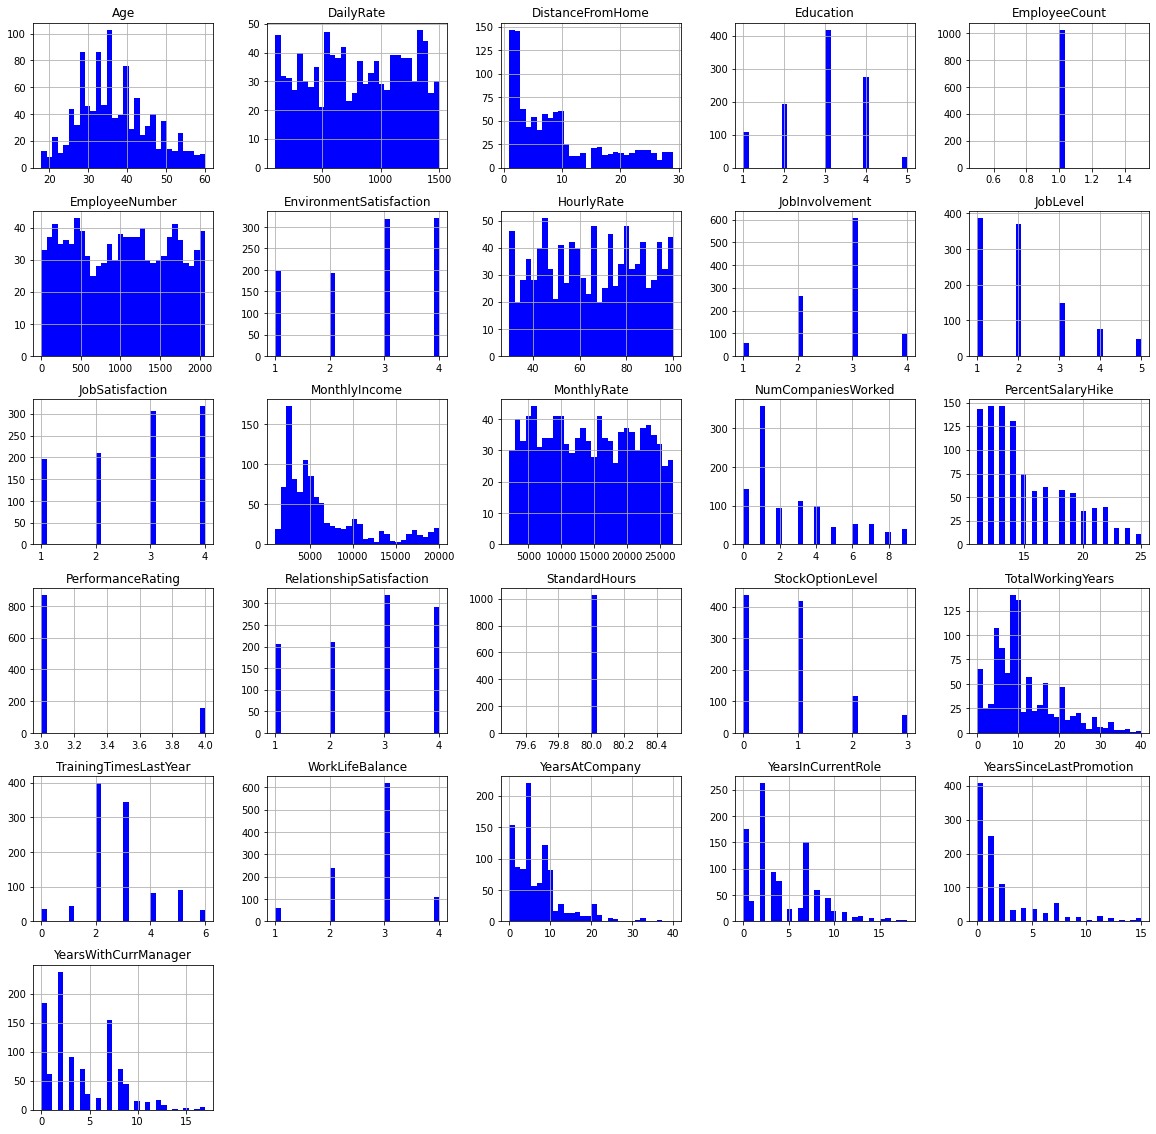

In [ ]:
X_train.hist(bins=30, figsize=(20,20), color="b")

Analicemos por separado los empleados que abandonan la empresa y los que se quedan.

In [ ]:
# vemos cuantos empleados dejan la empresa
left_df =  X_train[X_train["Attrition"] == "Yes"]
stay_df = X_train[X_train["Attrition"] == "No"]

# contamos el numero de empleados que se quedaron y que se fueron
print(f"El numero de empleados que se quedan es : {len(stay_df)} ie que el {np.round_(len(stay_df)/len(X_train), 2) * 100} % se quedan")
print(f"El numero de empleados que se fueron es : {len(left_df)} ie que el {np.round_(len(left_df)/len(X_train),2) * 100} % se fueron")

El numero de empleados que se quedan es : 862 ie que el 84.0 % se quedan
El numero de empleados que se fueron es : 167 ie que el 16.0 % se fueron


Al dividir el DataFrame entre empleados que se quedan y los que se fueron podemos sacar nuevas estadisticas de estos datos:

* **Age**: Podemos apreciar que los empleados que se quedan en la empresa tienden a ser mas grandes (en terminos de edad) a comparacion de los que se van.

* **DistanceFromeHome**: Efectivamente apreciamos que los empleados que se van tienden a vivir mas lejos de la empresa que los que se quedan.

* **YearsSinceLastPromotion**: Vemos que hay cierta relacion con los empleados que se fueron y la ultima vez que estos fueron promovidos en la empresa.

* **StockOptionLevel**: La adquisicion de acciones en la empresa tmb pareciera tener relacion con los empleados que se quedan y se fueron.

In [ ]:
left_df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,167.000000,167.000000,167.000000,167.000000,167.0,167.000000,167.000000,167.000000,167.000000,167.000000,...,167.000000,167.0,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,33.191617,752.844311,10.299401,2.856287,1.0,991.508982,2.485030,65.000000,2.556886,1.598802,...,2.556886,80.0,0.550898,8.017964,2.622754,2.604790,5.011976,2.856287,1.862275,2.766467
std,9.501385,404.987847,8.137756,0.989557,0.0,578.314958,1.211672,20.380418,0.780831,0.892133,...,1.117251,0.0,0.854884,7.148572,1.210480,0.835638,6.012024,3.198786,3.084974,3.073294
min,18.000000,104.000000,1.000000,1.000000,1.0,1.000000,1.000000,31.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,379.000000,3.000000,2.000000,1.0,493.000000,1.000000,48.000000,2.000000,1.000000,...,1.500000,80.0,0.000000,3.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000
50%,31.000000,719.000000,8.000000,3.000000,1.0,1004.000000,3.000000,64.000000,3.000000,1.000000,...,3.000000,80.0,0.000000,7.000000,2.000000,3.000000,3.000000,2.000000,1.000000,2.000000
75%,37.000000,1094.500000,16.000000,3.500000,1.0,1490.500000,4.000000,84.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,7.000000,4.000000,2.000000,5.000000
max,58.000000,1479.000000,29.000000,5.000000,1.0,2055.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,15.000000,15.000000,14.000000


In [ ]:
stay_df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,862.000000,862.000000,862.000000,862.000000,862.0,862.000000,862.000000,862.000000,862.000000,862.000000,...,862.000000,862.0,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000
mean,37.484919,817.264501,8.885151,2.950116,1.0,1028.607889,2.791183,65.273782,2.758701,2.143852,...,2.701856,80.0,0.849188,11.756381,2.806265,2.785383,7.357309,4.446636,2.248260,4.345708
std,8.801020,406.525752,8.036764,1.002236,0.0,606.831448,1.064916,20.470579,0.688220,1.125237,...,1.083279,0.0,0.840603,7.679621,1.246899,0.694508,6.087625,3.661179,3.233979,3.581307
min,18.000000,105.000000,1.000000,1.000000,1.0,5.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,479.250000,2.000000,2.000000,1.0,473.500000,2.000000,47.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,823.500000,7.000000,3.000000,1.0,1043.500000,3.000000,65.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,6.000000,3.000000,1.000000,3.000000
75%,43.000000,1183.500000,12.000000,4.000000,1.0,1572.500000,4.000000,83.000000,3.000000,3.000000,...,4.000000,80.0,1.000000,16.000000,3.000000,3.000000,10.000000,7.000000,3.000000,7.000000
max,60.000000,1498.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,38.000000,6.000000,4.000000,37.000000,18.000000,15.000000,17.000000


Ploteamos los distintos histogramas. (Empleados que se quedaron vs Empleados que se fueron).

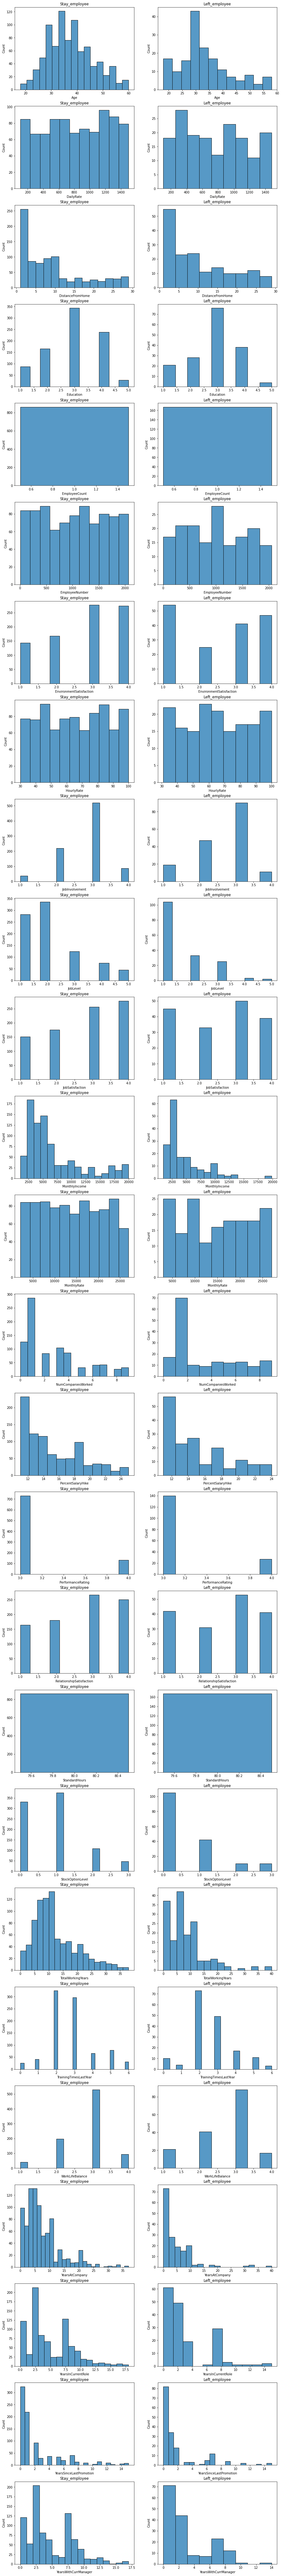

In [ ]:
num_feat = [feature for feature in X_train.columns if (X_train[feature].dtype != np.object_)]

f, axs = plt.subplots(len(num_feat), 2, figsize=(15, 150))

for i in range(len(num_feat)):
  for j in range(2):
    if j==0:
      sns.histplot(stay_df[num_feat[i]], ax=axs[i, j]).set(title="Stay_employee")
    else:
      sns.histplot(left_df[num_feat[i]], ax=axs[i, j]).set(title="Left_employee")

## Graficos de barras.

Vemos el % de desercion laboral.

In [ ]:
X_train["Attrition"].value_counts(normalize=True)

No     0.837707
Yes    0.162293
Name: Attrition, dtype: float64

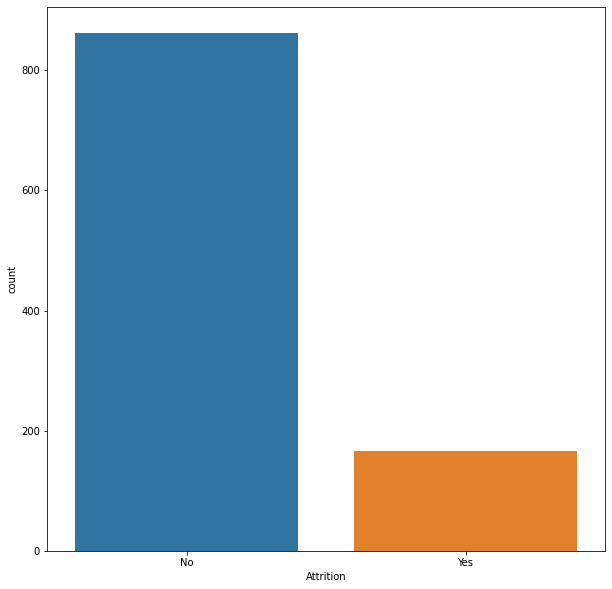

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(x="Attrition", data=X_train)

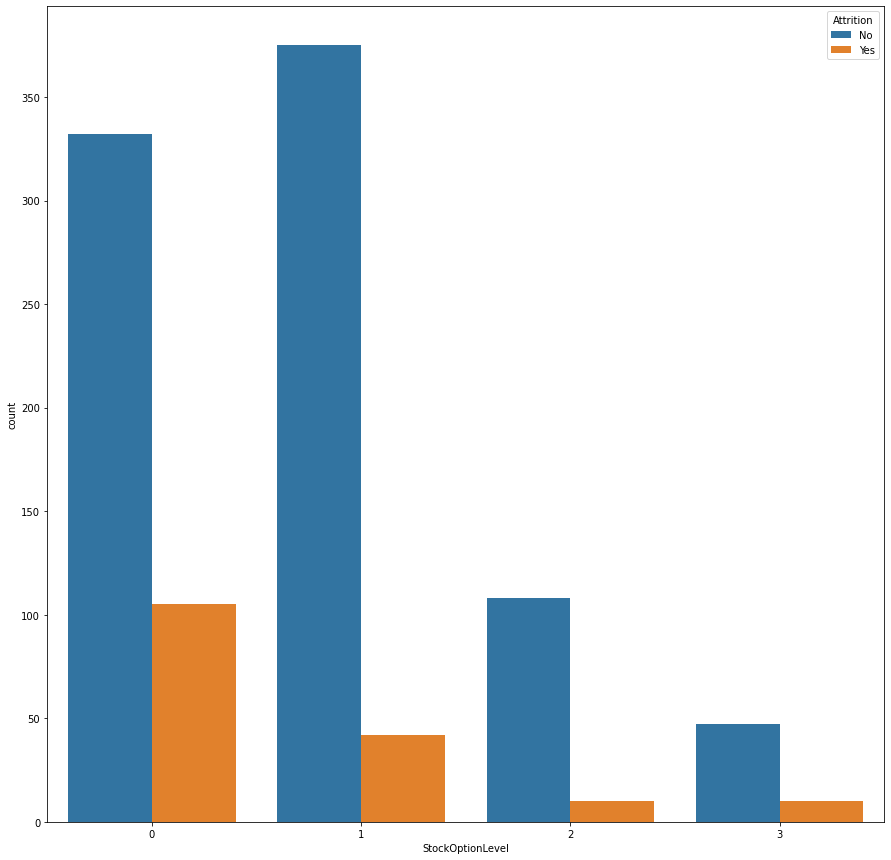

In [ ]:
plt.figure(figsize=(15,15))
sns.countplot(x="StockOptionLevel", hue = "Attrition", data = X_train)

Podemos observar que pareciera ser que los empleados mas jovenes son los mas propensos a irse de la empresa

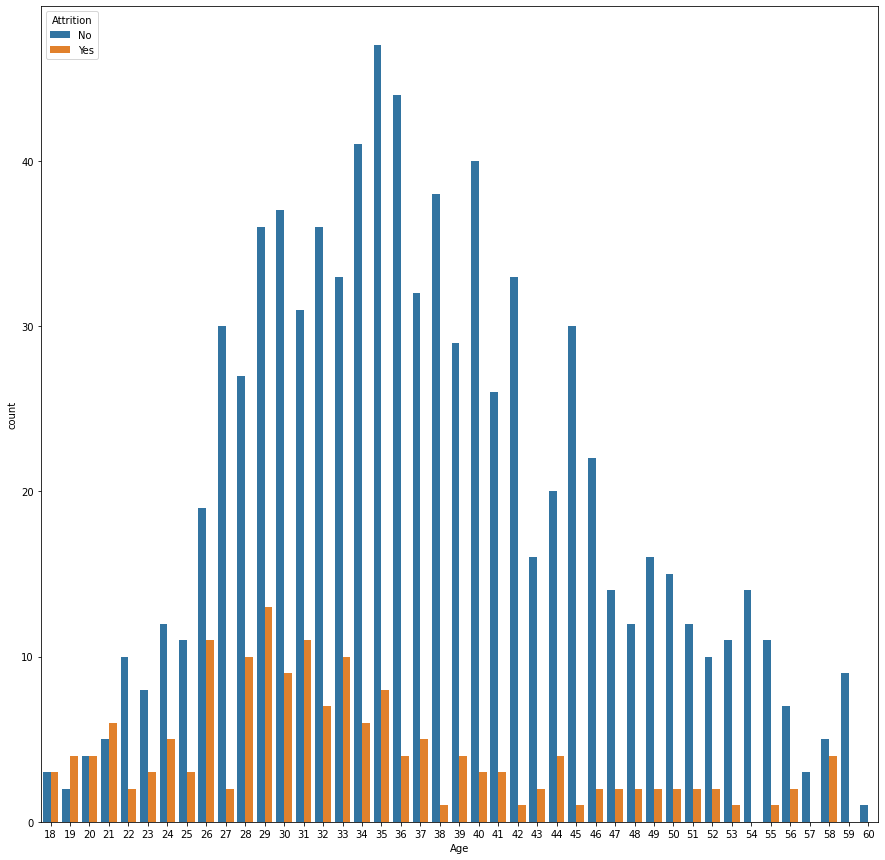

In [ ]:
plt.figure(figsize=(15,15))
sns.countplot(x="Age", hue = "Attrition", data = X_train)

Podemos hacer las siguientes observaciones a partir de los graficos.

* Pareciera ser que los empleados solteros tienden mas a irse en comparacion con los casados ​​y divorciados.

* Los empleados menos involucrados tienden a dejar la empresa.

* Los menos experimentados (nivel laboral bajo) tienden a dejar la empresa.

* Los representantes de ventas tienden mas a irse en comparacion con cualquier otro jobrole.


[Text(0, 0, 'Sales Executive'),
 Text(0, 0, 'Sales Representative'),
 Text(0, 0, 'Human Resources'),
 Text(0, 0, 'Laboratory Technician'),
 Text(0, 0, 'Research Scientist'),
 Text(0, 0, 'Manager'),
 Text(0, 0, 'Healthcare Representative'),
 Text(0, 0, 'Manufacturing Director'),
 Text(0, 0, 'Research Director')]

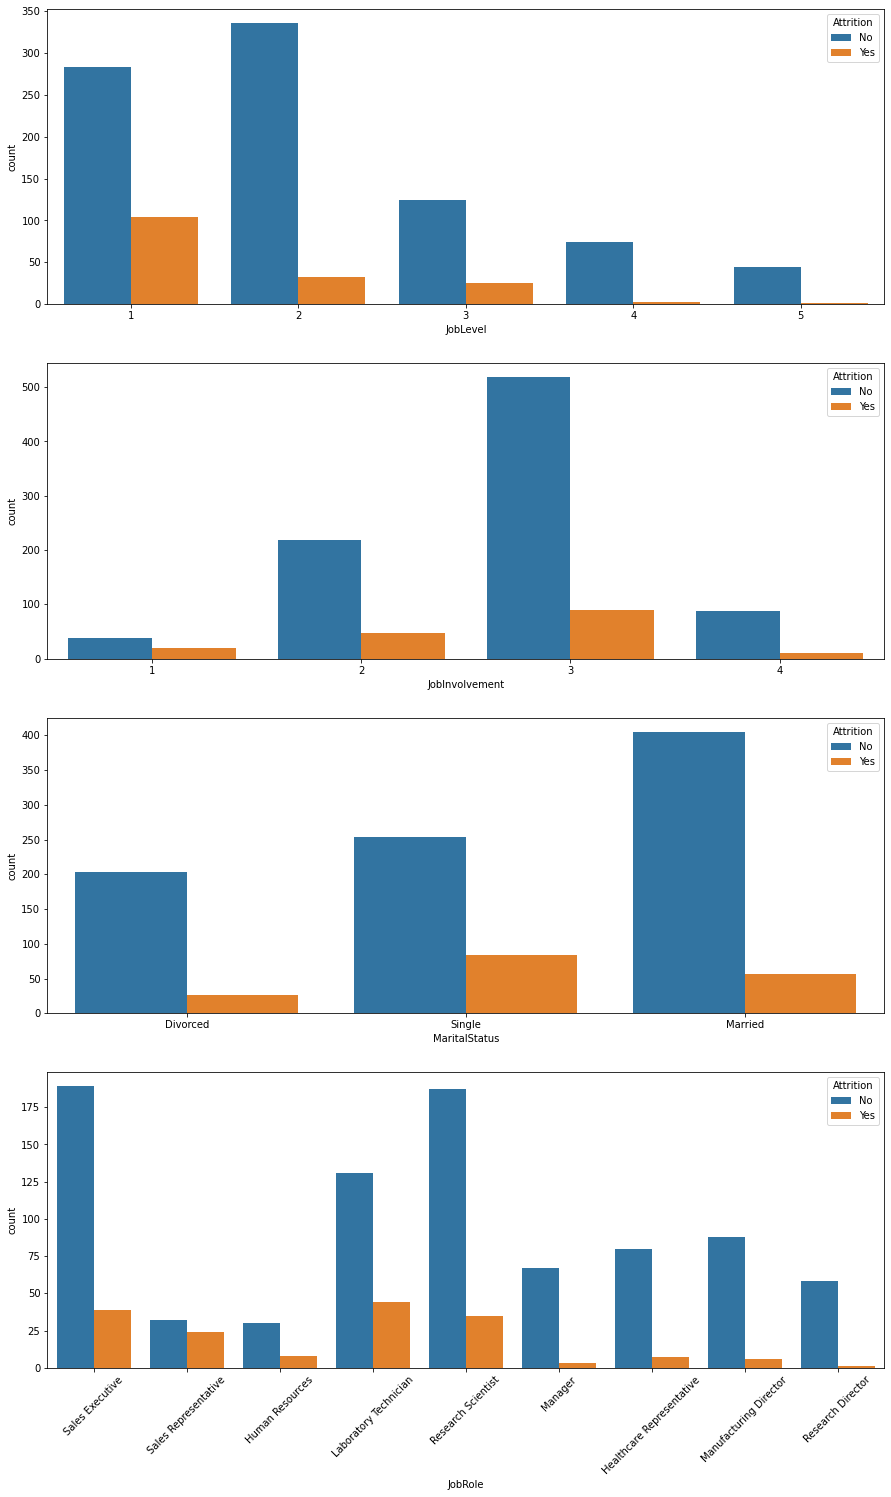

In [ ]:
fig, axs = plt.subplots(4,1,figsize=(15,25))

sns.countplot(x="JobLevel", hue="Attrition", data=X_train, ax=axs[0])
sns.countplot(x="JobInvolvement", hue="Attrition", data=X_train, ax=axs[1])
sns.countplot(x="MaritalStatus", hue="Attrition", data=X_train, ax=axs[2])
sns.countplot(x="JobRole", hue="Attrition", data=X_train, ax=axs[3]).set_xticklabels(X_train["JobRole"].unique(), rotation=45)

Vemos que hay casi el doble de hombres que de mujeres en el departamento de `reserch & development`.

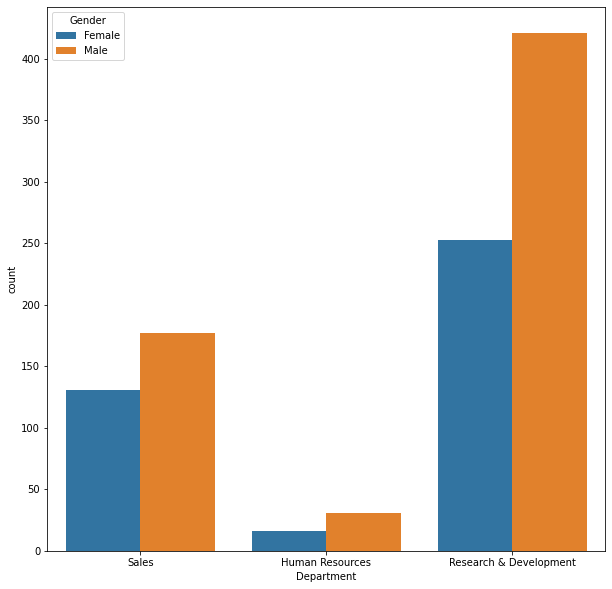

In [ ]:
plt.figure(figsize=(10,10))

sns.countplot(x="Department", hue="Gender", data=X_train)

Porcentaje de desercion de acuerdo al departamento.

In [ ]:
X_train_tmp = X_train.copy()
X_train_tmp["Attrition_ord_enc"] = np.where(X_train["Attrition"] == "Yes", 1, 0)

mean_tgt_group_by_department = X_train_tmp.groupby(by="Department")["Attrition_ord_enc"].mean()
mean_tgt_group_by_department

Department
Human Resources           0.170213
Research & Development    0.140950
Sales                     0.207792
Name: Attrition_ord_enc, dtype: float64

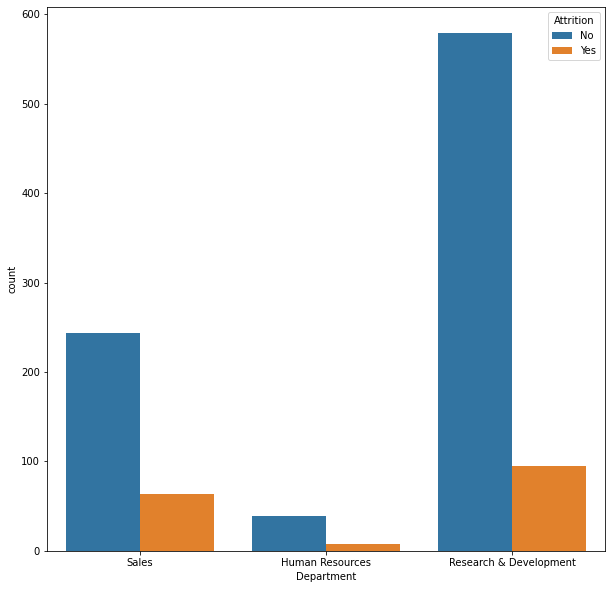

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(x="Department", hue="Attrition", data=X_train)

Porcentaje de desercion de acuerdo al genero.

In [ ]:
X_train_tmp["Gender_ord_enc"] = np.where(X_train_tmp["Gender"], 1, 0)

mean_tgt_group_by_gen = X_train_tmp.groupby(by="Gender")["Attrition_ord_enc"].mean()
mean_tgt_group_by_gen

Gender
Female    0.150000
Male      0.170111
Name: Attrition_ord_enc, dtype: float64

## Graficos de densidad.

Gracias al grafico de densidad podemos afirmar rotundamente que los empleados que viven mas lejos tienden mas a abandonar la empresa en comparacion de los que viven mas cerca.

Entre otras hipotesis que salen de analizar las sig funciones de densidad.

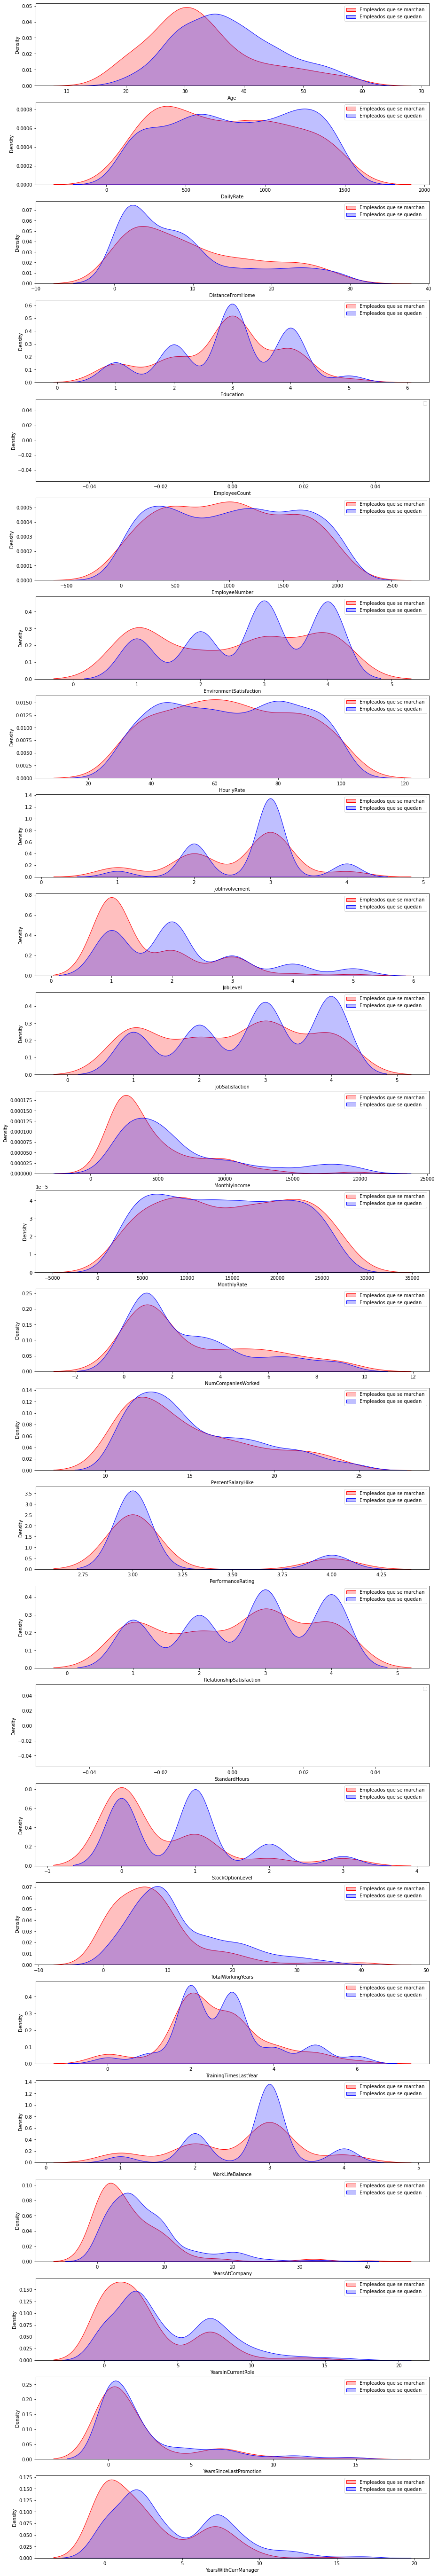

In [ ]:
f, axs = plt.subplots(len(num_feat),1, figsize=(15,100))

for i in range(len(num_feat)):
  sns.kdeplot(left_df[num_feat[i]], label="Empleados que se marchan", shade= True, color= "r", ax=axs[i], warn_singular=False)
  sns.kdeplot(stay_df[num_feat[i]], label="Empleados que se quedan", shade= True, color= "b", ax=axs[i], warn_singular=False)
  axs[i].legend()

Nuevamente podemos confirmar nuestra hipotesis de que los empleados nuevos o los que no llevan tanto tiempo trabajando en la empresa tienen mas probabilidades de irse a comparacion de los empleados que llevan cierto tiempo trabajando en la empresa (aprox los empleados que vienen trabajando mas hace 7 years tienden a permanecer en la empresa)

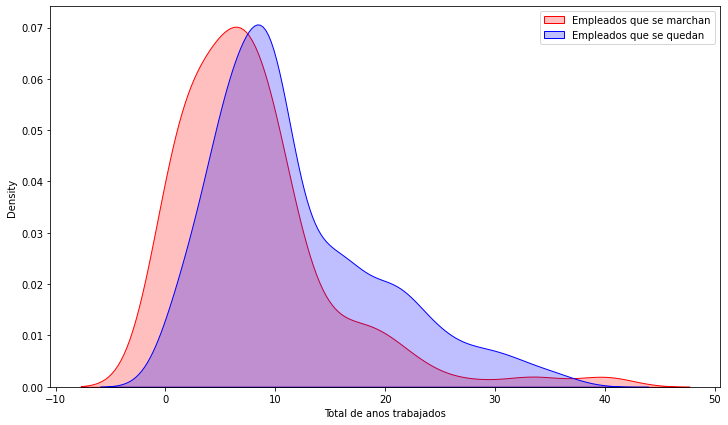

In [ ]:
plt.figure(figsize=(12,7))
plt.xlabel("Total de anos trabajados")

sns.kdeplot(left_df["TotalWorkingYears"], label="Empleados que se marchan", shade=True, color="r")
sns.kdeplot(stay_df["TotalWorkingYears"], label="Empleados que se quedan", shade=True, color="b")

plt.legend()

Del siguiente grafico de densidad podemos apreciar que los empleados que llevan menos tiempo a cargo de un mismo manager tmb tienden a ser mas probables de abandonar la empresa a comparacion de los que llevan mayor tiempo con una misma persona en el cargo de manager

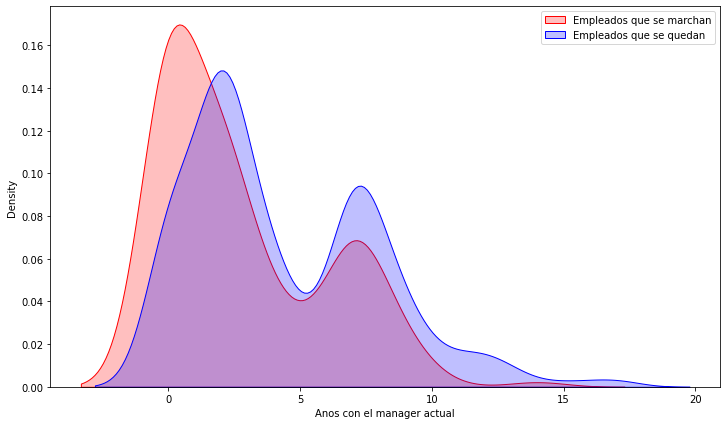

In [ ]:
plt.figure(figsize=(12,7))
plt.xlabel("Anos con el manager actual")

sns.kdeplot(left_df["YearsWithCurrManager"], label="Empleados que se marchan", shade= True, color= "r" )
sns.kdeplot(stay_df["YearsWithCurrManager"], label="Empleados que se quedan", shade= True, color= "b" )
plt.legend()

Podemos ver que SI hay una diferencia en el sueldo entre los empleados que se marchan y los empleados que se quedan.

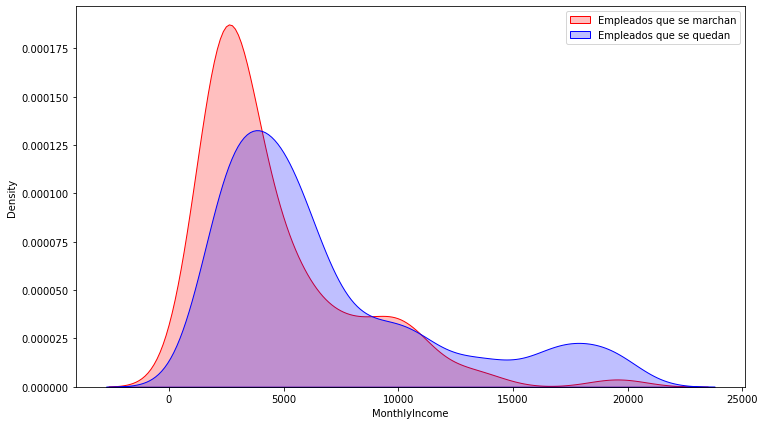

In [ ]:
plt.figure(figsize=(12,7))
plt.xlabel("MonthlyIncome")

sns.kdeplot(left_df["MonthlyIncome"], label="Empleados que se marchan", shade= True, color= "r" )
sns.kdeplot(stay_df["MonthlyIncome"], label="Empleados que se quedan", shade= True, color= "b" )
plt.legend()

## Graficos de cajas.

Analizamos el sueldo de acuerdo al genero y podemos ver que no existe una diferencia en el sueldo medio de acuerdo al genero.

**OBS:** si bien no pareciera haber una diferencia notoria en la media/cuartiles/rango IC, si se puede apreciar que las observaciones con genero Masculino presenta muchos mas outliars que las obs con genero Femenino en relacion al sueldo...

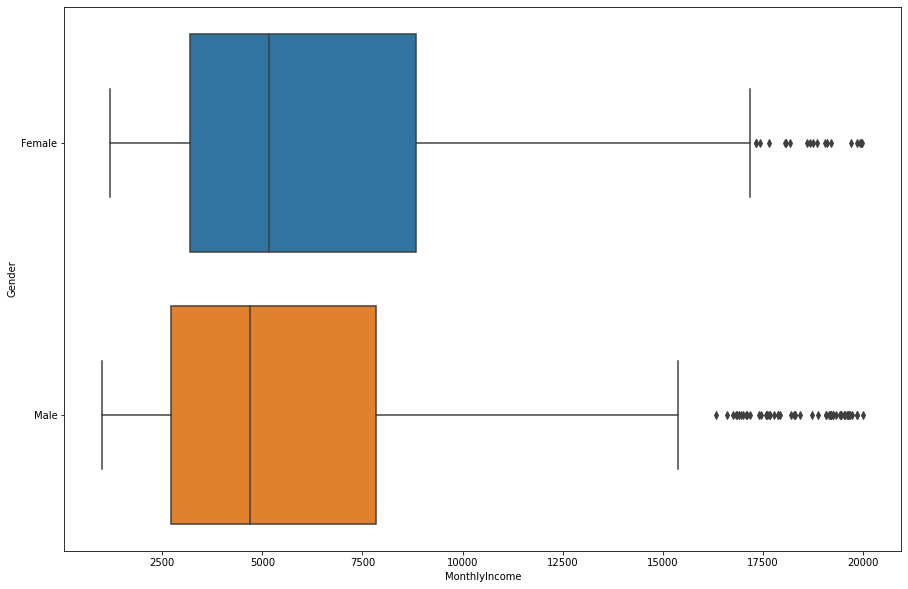

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(x="MonthlyIncome", y="Gender", data=X_train_tmp)

In [ ]:
X_train_tmp.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager', 'Attrition_ord_enc', 'Gender_ord_enc'],
      dtype='object')

In [ ]:
X_train_tmp[["MaritalStatus"]].value_counts(normalize=True)

MaritalStatus
Married          0.448980
Single           0.327502
Divorced         0.223518
dtype: float64

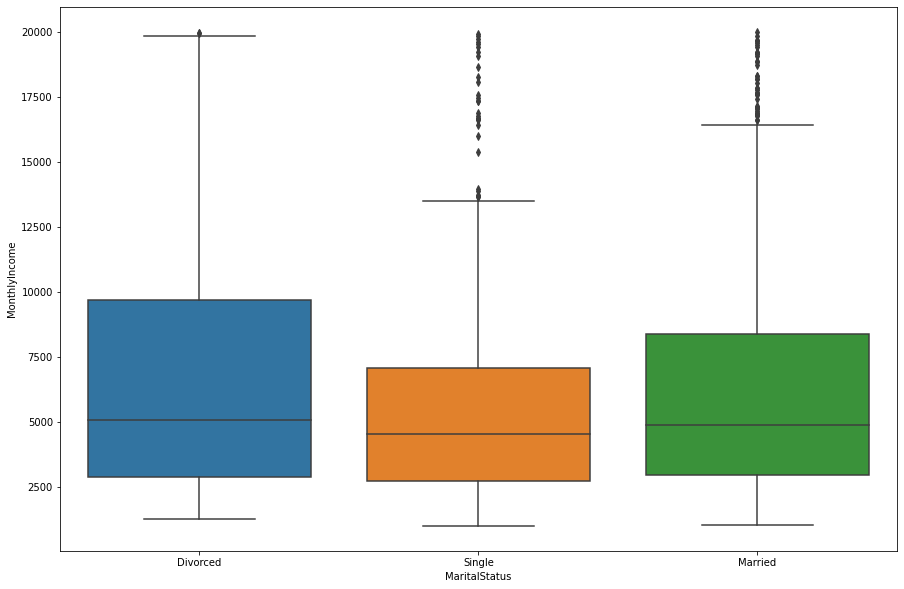

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(x="MaritalStatus", y="MonthlyIncome", data=X_train_tmp)

Podemos ver el monthlyIncome de acuerdo al jobStatisfaction.

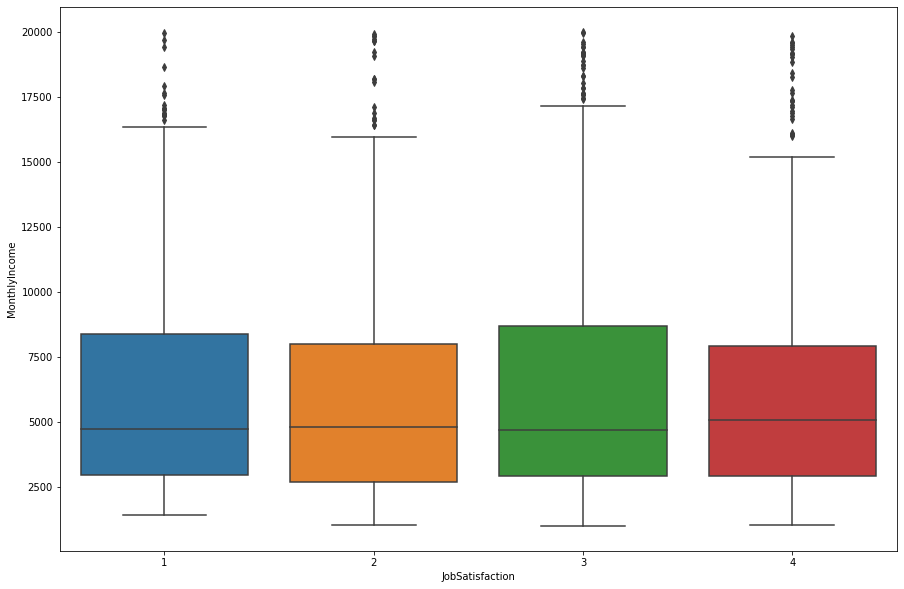

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(x="JobSatisfaction", y="MonthlyIncome", data=X_train_tmp)

Podemos ver cuales son los rangos de sueldo que maneja la empresa de acuerdo al puesto de trabajo.

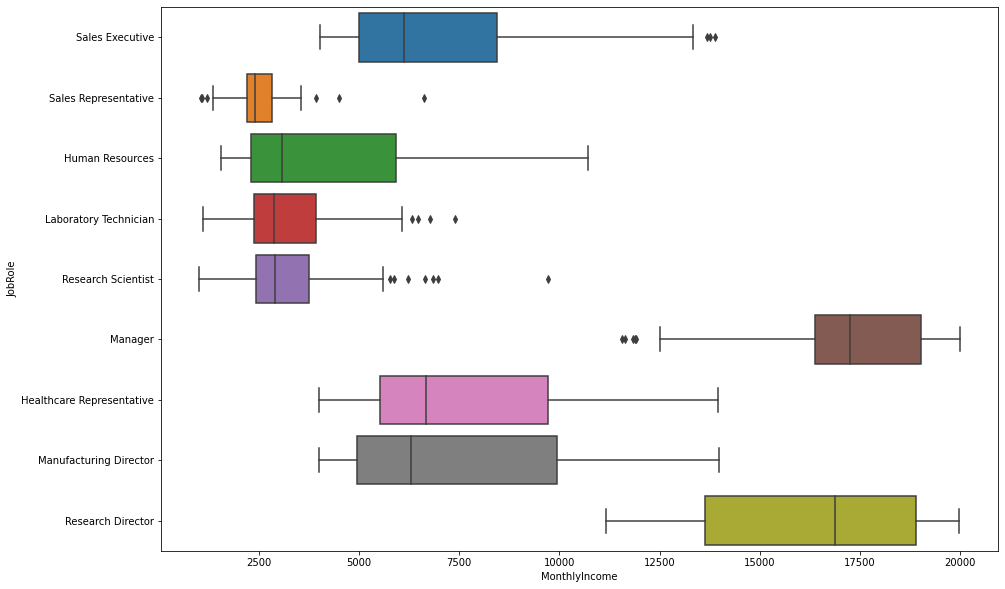

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(x="MonthlyIncome", y="JobRole", data=X_train_tmp)

# SELECCION Y TRATAMIENTO DE FEATURES.

## Data transformation.

Vamos a transformar la distribucion de aquellos features que presenten skeness en su distribucion.

Para ello usaremos la funcion skew() la cual realiza el sig calculo:

<h2>$\sum_{i=1}^{n} \frac{(X_{i} - \mu)^3}{(N-1)*\sigma}$<h2/>

**OBS:** Cabe destacar que estamos dividiendo por la desviacion estandar, por lo que necesitamos que esta sea distinta de cero.

In [ ]:
import scipy.stats as stats

# plotea un histograma y un q-q plot
def diagnostic_plots(df, variable):
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)

    plt.show()

In [ ]:
# obtenemos las variables numericas CONTINUAS
num_feats = [feat for feat in X_train.columns if X_train[feat].dtype != np.object_ and X_train[feat].nunique() >= 10]
num_feats

['Age',
 'DailyRate',
 'DistanceFromHome',
 'EmployeeNumber',
 'HourlyRate',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'TotalWorkingYears',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [ ]:
# eliminamos EmployeeNumber ya que no es de utilidad para este analisis
num_feats.remove("EmployeeNumber")

In [ ]:
skew_cols = X_train[num_feats].skew()
skew_cols

Age                        0.396901
DailyRate                 -0.040965
DistanceFromHome           0.974433
HourlyRate                -0.002535
MonthlyIncome              1.378482
MonthlyRate                0.042857
NumCompaniesWorked         0.992097
PercentSalaryHike          0.811977
TotalWorkingYears          1.108408
YearsAtCompany             1.816827
YearsInCurrentRole         0.950422
YearsSinceLastPromotion    1.962879
YearsWithCurrManager       0.847614
dtype: float64

Obtenemos los features que presenten una skewness mayor a 0.75. A estos features le aplicaremos la transformacion logaritmica.

In [ ]:
feat_to_transform = [feat for feat in skew_cols.index if skew_cols.loc[feat] > 0.75]
feat_to_transform

['DistanceFromHome',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'TotalWorkingYears',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

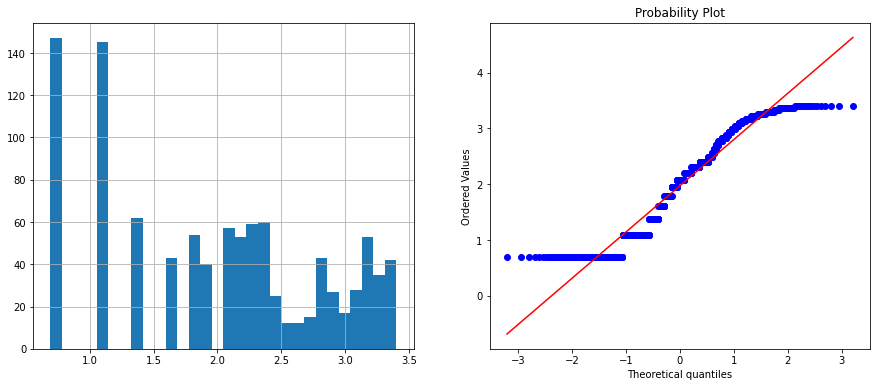

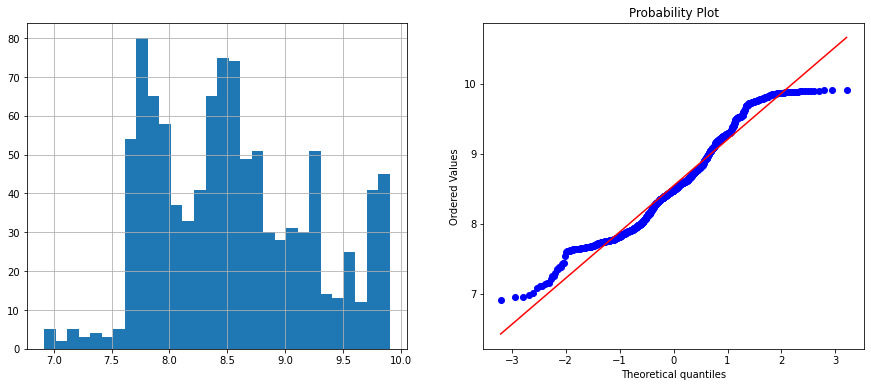

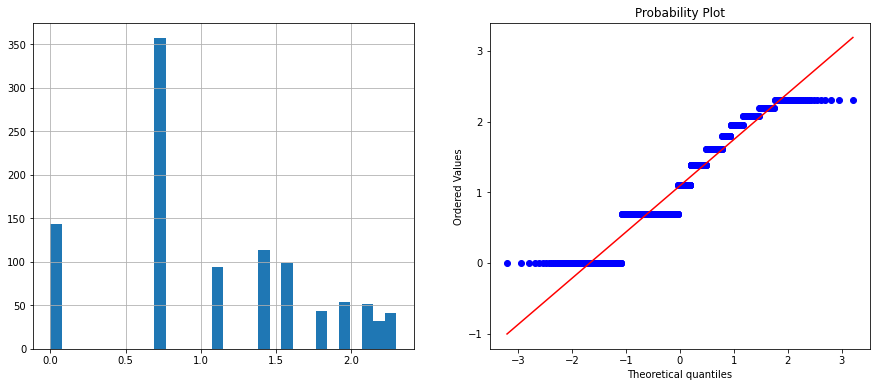

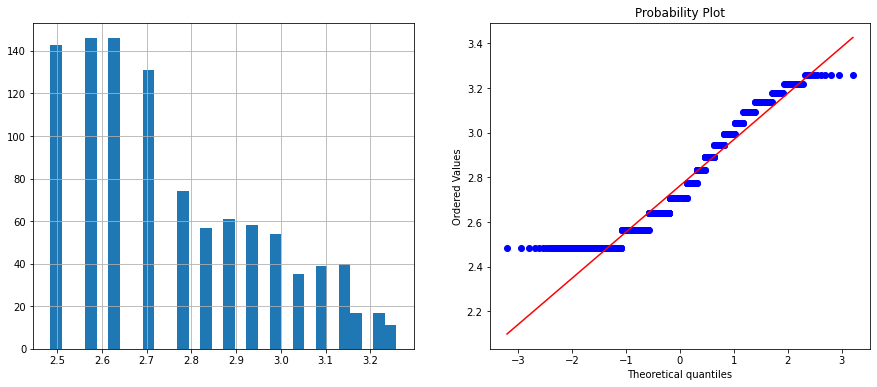

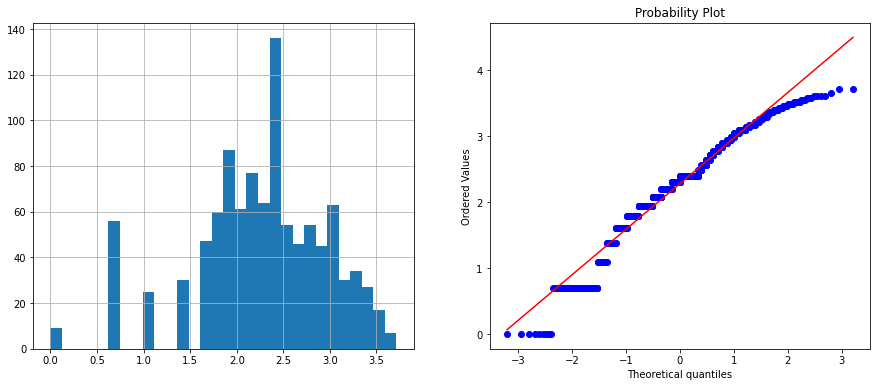

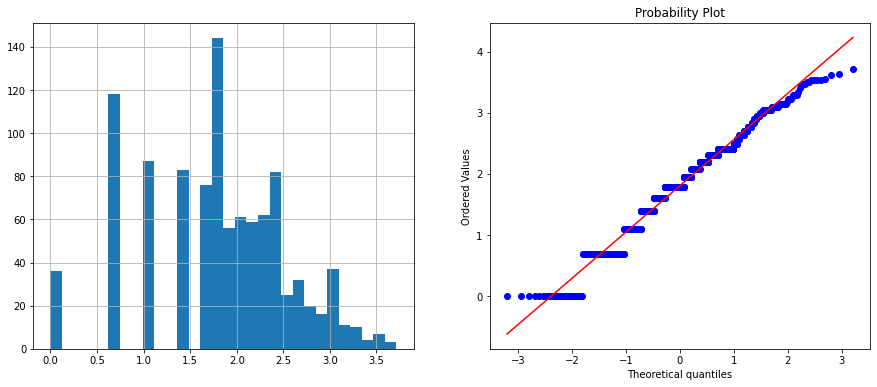

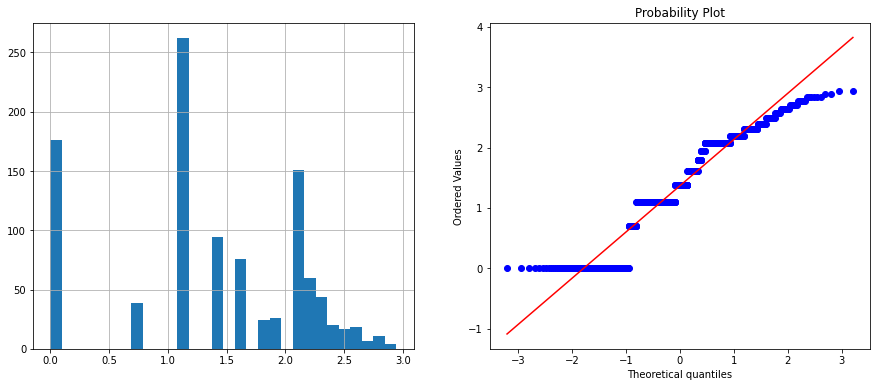

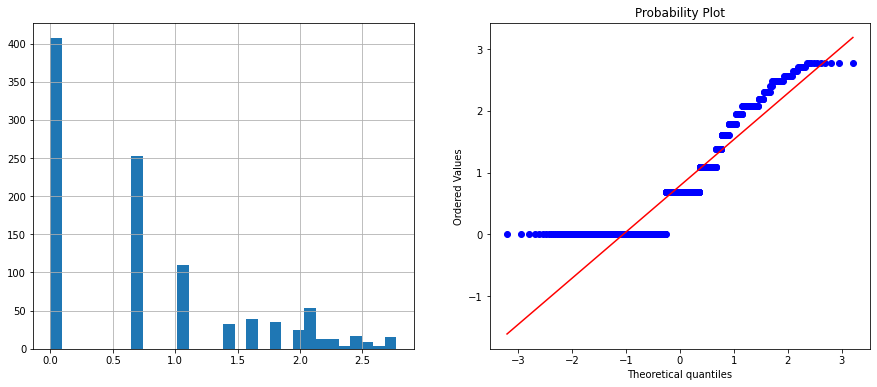

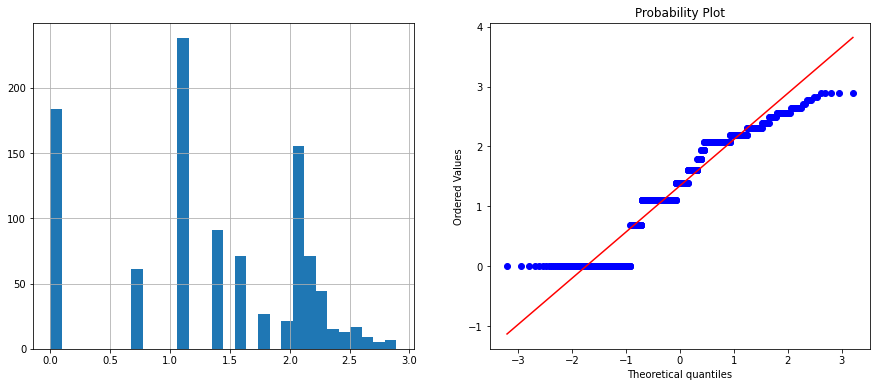

In [ ]:
# aplicamos la transformacion log1p
for feat in feat_to_transform:
  X_train[feat] = np.log1p(X_train[feat])
  X_test[feat] = np.log1p(X_test[feat])

# ploteamos la nueva distribucion
for feat in feat_to_transform:
  diagnostic_plots(X_train, feat)

## Tratamiento de variables categoricas.

In [ ]:
# obtenemos las variables categoricas
cat_feats = [feature for feature in X_train.columns if X_train[feature].dtype == np.object_][1:]
cat_feats

['BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'Over18',
 'OverTime']

### Cardinalidades y valores raros.

In [ ]:
dict_of_cardin_r = dict_of_cardinalities(X_train, cat_feats)

Podemos ver los cardinales de nuestros features categoricos y tmb el porcentaje de ocurrencia de cada valor que se puede tomar en cada feature categorico.

**OBS:** 
* En el feature **"Department"** tenemos el valor `Human Resources` con una frecuencia < 4.6%.
* En el feature **"EducationField"** tenemos los valores `Other` & `Human Resources` con frecuencias < 5.3% y 2.1% respc.
* En el feature **"JobRole"** tenemos los valores `HumanResources` & `Sales Representative` y `Research Director` con frecuencias < a 3.7%, 5.5% y 5.8% respc.

In [ ]:
for k in dict_of_cardin_r:
  print(f"Feature: {k} With cardinality: {dict_of_cardin_r[k][0]} \n{dict_of_cardin_r[k][1:]}\n")
  print("========================================")

Feature: BusinessTravel With cardinality: 3 
(Travel_Rarely        0.710398
Travel_Frequently    0.186589
Non-Travel           0.103013
Name: BusinessTravel, dtype: float64,)

Feature: Department With cardinality: 3 
(Research & Development    0.655005
Sales                     0.299320
Human Resources           0.045675
Name: Department, dtype: float64,)

Feature: EducationField With cardinality: 6 
(Life Sciences       0.416910
Medical             0.312925
Marketing           0.106900
Technical Degree    0.090379
Other               0.052478
Human Resources     0.020408
Name: EducationField, dtype: float64,)

Feature: Gender With cardinality: 2 
(Male      0.611273
Female    0.388727
Name: Gender, dtype: float64,)

Feature: JobRole With cardinality: 9 
(Sales Executive              0.221574
Research Scientist           0.215743
Laboratory Technician        0.170068
Manufacturing Director       0.091351
Healthcare Representative    0.084548
Manager                      0.068027
Resear

Para cada feature agrupamos en una misma categoria llamada Rare aquellos valores que tengan una frecuencia menor al 7%.

Esto lo hacemos para reducir el feature-space.

In [ ]:
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

for feat in cat_feats:
  X_train_enc, X_test_enc = group_rare_labels(X_train_enc, X_test_enc, feat, 0.07)

In [ ]:
dict_of_cardin_r = dict_of_cardinalities(X_train_enc, cat_feats)

for k in dict_of_cardin_r:
  print(f"Feature: {k} With cardinality: {dict_of_cardin_r[k][0]} \n{dict_of_cardin_r[k][1:]}\n")
  print("========================================")

Feature: BusinessTravel With cardinality: 3 
(Travel_Rarely        0.710398
Travel_Frequently    0.186589
Non-Travel           0.103013
Name: BusinessTravel, dtype: float64,)

Feature: Department With cardinality: 3 
(Research & Development    0.655005
Sales                     0.299320
Rare                      0.045675
Name: Department, dtype: float64,)

Feature: EducationField With cardinality: 5 
(Life Sciences       0.416910
Medical             0.312925
Marketing           0.106900
Technical Degree    0.090379
Rare                0.072886
Name: EducationField, dtype: float64,)

Feature: Gender With cardinality: 2 
(Male      0.611273
Female    0.388727
Name: Gender, dtype: float64,)

Feature: JobRole With cardinality: 6 
(Sales Executive              0.221574
Rare                         0.216715
Research Scientist           0.215743
Laboratory Technician        0.170068
Manufacturing Director       0.091351
Healthcare Representative    0.084548
Name: JobRole, dtype: float64,)

Fe

Chequeamos que no haya valores que sean unicos del test-set, puesto que podria traer problemas mas adelante.

In [ ]:
for feat in cat_feats:
  unique_train_values = [value for value in X_train[feat].unique() if value not in X_test[feat].unique()]
  unique_test_values = [value for value in X_test[feat] if value not in  X_train[feat].unique()]  

  print(f"\nEl feature {feat} en el X_train tiene los sig valores unicos {unique_train_values}\n")
  print(f"\nEl feature {feat} en el X_test tiene los sig valores unicos {unique_test_values}\n")
  print("============================================")


El feature BusinessTravel en el X_train tiene los sig valores unicos []


El feature BusinessTravel en el X_test tiene los sig valores unicos []


El feature Department en el X_train tiene los sig valores unicos []


El feature Department en el X_test tiene los sig valores unicos []


El feature EducationField en el X_train tiene los sig valores unicos []


El feature EducationField en el X_test tiene los sig valores unicos []


El feature Gender en el X_train tiene los sig valores unicos []


El feature Gender en el X_test tiene los sig valores unicos []


El feature JobRole en el X_train tiene los sig valores unicos []


El feature JobRole en el X_test tiene los sig valores unicos []


El feature MaritalStatus en el X_train tiene los sig valores unicos []


El feature MaritalStatus en el X_test tiene los sig valores unicos []


El feature Over18 en el X_train tiene los sig valores unicos []


El feature Over18 en el X_test tiene los sig valores unicos []


El feature OverTime en el 

### Categorical encoding.

Codificamos el target con 1s y 0s, a esto lo hacemos pues los metodos de "Ordered Integer Encoding" y "Ratio Encoding" necesitan hacer cuentas con el target.

In [ ]:
X_train_enc["Attrition"] = np.where(X_train_enc["Attrition"] == "Yes", 1, 0)
X_test_enc["Attrition"] = np.where(X_test_enc["Attrition"] == "Yes", 1, 0)

y_train = X_train_enc["Attrition"].copy()
y_test = X_test_enc["Attrition"].copy()

**Ordinal Encoding**

In [ ]:
X_train_OE, X_test_OE = ordinal_encoding(X_train_enc, X_test_enc, cat_feats)

In [ ]:
X_train_OE[cat_feats].head()

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
338,0,0,0,0,0,0,0,0
363,0,0,0,0,1,1,0,1
759,0,1,1,1,1,1,0,0
793,0,2,2,1,2,0,0,0
581,0,2,2,1,2,2,0,0


**Counting Encoding**

In [ ]:
X_train_CE, X_test_CE = counting_encoding(X_train_enc, X_test_enc, cat_feats)

In [ ]:
X_train_CE[cat_feats].head()

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
338,731,308,110,400,228,230,1029,747
363,731,308,110,400,223,337,1029,282
759,731,47,322,629,223,337,1029,747
793,731,674,429,629,175,230,1029,747
581,731,674,429,629,175,462,1029,747


Podemos ver que nuestras variables codificadas con Counting Encoding no presentan ninguna relacion lineal con nuestro target.

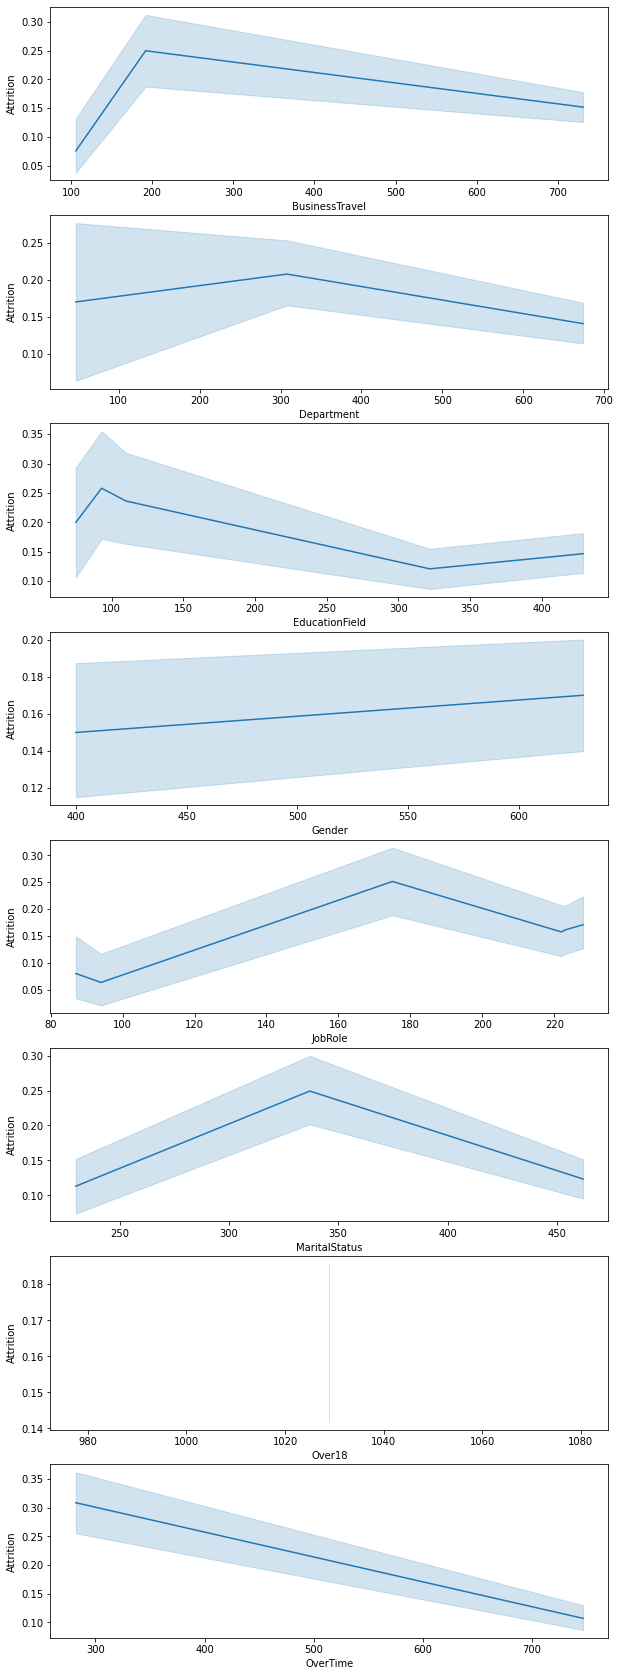

In [ ]:
f,axs = plt.subplots(len(cat_feats), 1, figsize=(10,30))
for feat_i in range(len(cat_feats)):
  sns.lineplot(x=X_train_CE[cat_feats[feat_i]], y= X_train_CE["Attrition"], ax=axs[feat_i])

Vemos que al codificar con este aprouch y el sig, obtenemos una relacion lineal con el target.
Ahora nuestros features que eran categoricos tienen una relacion lineal con el target.

**Ordered Integer Encoding**

In [ ]:
X_train_OIE, X_test_OIE = ordered_integer_encoding(X_train_enc, X_test_enc, cat_feats,"Attrition")

In [ ]:
X_train_OIE[cat_feats].head()

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
338,1,2,3,0,4,0,0,0
363,1,2,3,0,3,2,0,1
759,1,1,0,1,3,2,0,0
793,1,0,1,1,5,0,0,0
581,1,0,1,1,5,1,0,0


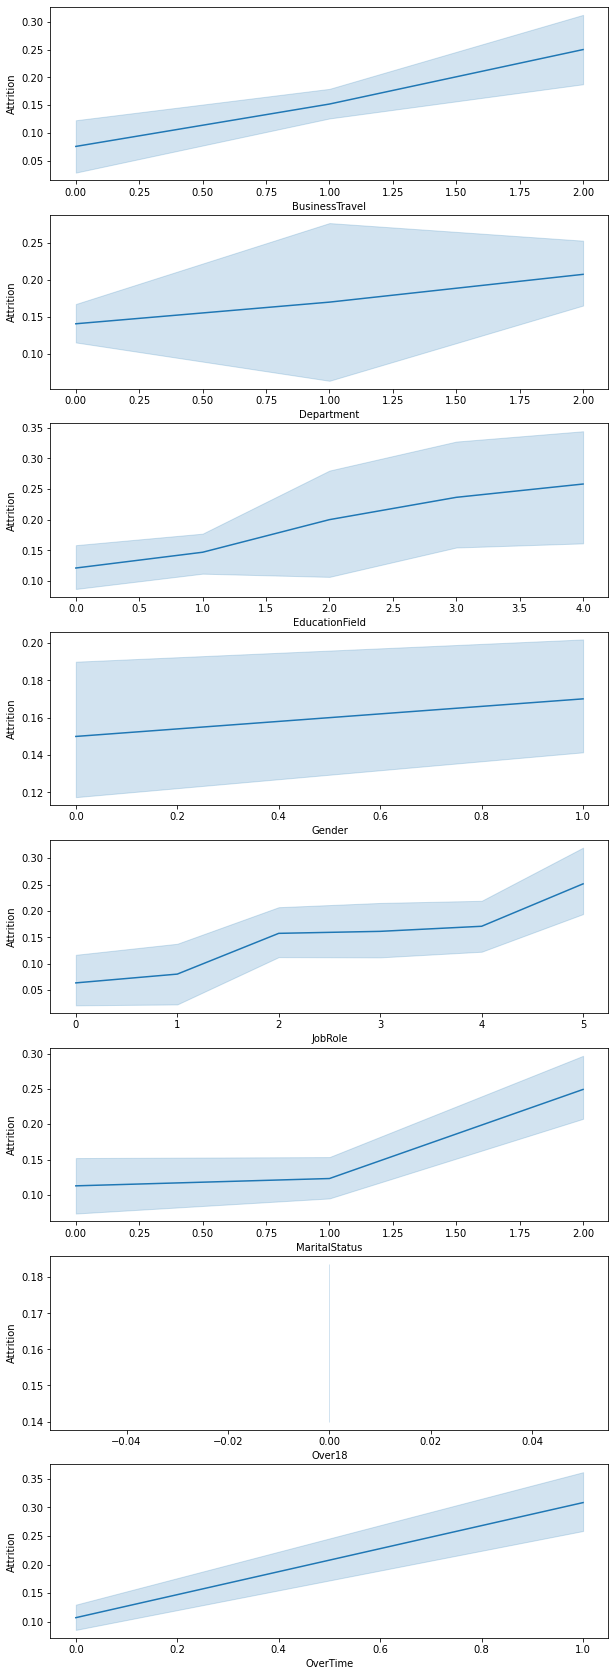

In [ ]:
f,axs = plt.subplots(len(cat_feats), 1, figsize=(10,30))
for feat_i in range(len(cat_feats)):
  sns.lineplot(x=X_train_OIE[cat_feats[feat_i]], y= X_train_OIE["Attrition"], ax=axs[feat_i])

**Probability Ratio Encoding (target discreto)**

In [ ]:
X_train_RE, X_test_RE = probability_ratio_encoding(X_train_enc, X_test_enc, cat_feats,"Attrition")

In [ ]:
X_train_RE.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
338,30,0,0.179032,570,0.262295,1.791759,3,0.309524,1,456,...,3,80,3,2.397895,2,3,2.397895,2.302585,0.693147,1.098612
363,33,1,0.179032,350,0.262295,1.791759,3,0.309524,1,485,...,2,80,0,0.693147,2,3,0.693147,0.000000,0.000000,0.000000
759,45,0,0.179032,788,0.205128,3.218876,4,0.137809,1,1049,...,1,80,0,1.945910,3,3,1.945910,1.386294,0.000000,1.609438
793,28,0,0.179032,895,0.164076,2.772589,2,0.172131,1,1102,...,4,80,1,1.609438,5,2,1.609438,1.098612,1.098612,1.098612
581,30,0,0.179032,921,0.164076,0.693147,3,0.172131,1,806,...,3,80,2,2.079442,2,3,1.098612,1.098612,0.000000,1.098612


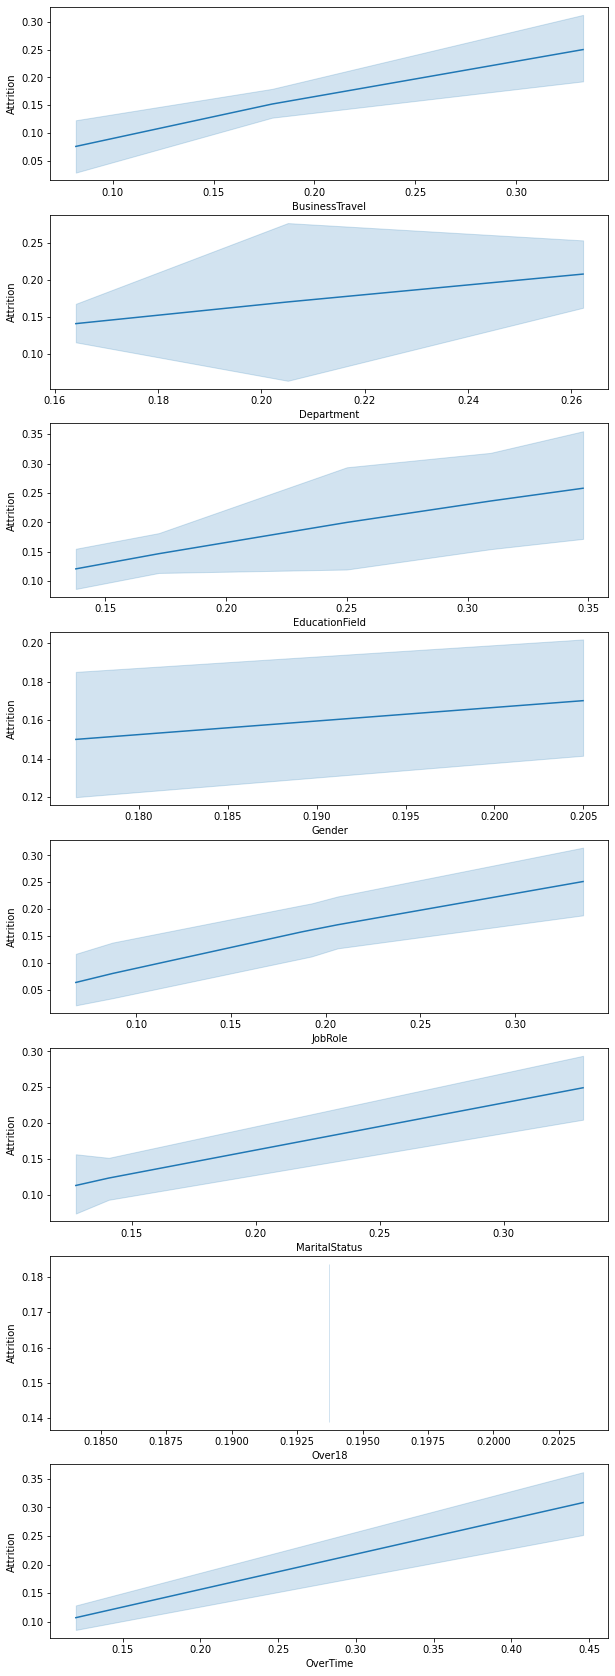

In [ ]:
f,axs = plt.subplots(len(cat_feats), 1, figsize=(10,30))
for feat_i in range(len(cat_feats)):
  sns.lineplot(x=X_train_RE[cat_feats[feat_i]], y= X_train_RE["Attrition"], ax=axs[feat_i])


### Categorical encoding performance.

Analizamos, a traves de la metrica roc-auc, cuales de las codificaciones es la que mejor resultados arroja.

In [ ]:
def run_randomForests(X_train, X_test, y_train, y_test):

    rf = RandomForestClassifier(n_estimators=50, random_state=0, max_depth=3)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
  
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = rf.predict_proba(X_test)
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

**Random Forest con diferentes categorical encoding aprouchs**

In [ ]:
run_randomForests(X_train_OE[cat_feats], X_test_OE[cat_feats], y_train, y_test)

Train set
Random Forests roc-auc: 0.7599267821665254
Test set
Random Forests roc-auc: 0.7324412783981517


In [ ]:
run_randomForests(X_train_CE[cat_feats], X_test_CE[cat_feats], y_train, y_test)

Train set
Random Forests roc-auc: 0.7624102143740362
Test set
Random Forests roc-auc: 0.7266076241817481


In [ ]:
run_randomForests(X_train_OIE[cat_feats], X_test_OIE[cat_feats], y_train, y_test)

Train set
Random Forests roc-auc: 0.7811106325631799
Test set
Random Forests roc-auc: 0.7446669233731229


In [ ]:
run_randomForests(X_train_RE[cat_feats], X_test_RE[cat_feats], y_train, y_test)

Train set
Random Forests roc-auc: 0.781152312544285
Test set
Random Forests roc-auc: 0.7446669233731229


**Conclusion:** Vemos que el mejor aprouch para tratar las variables categoricas es el apruch de ratio encoding.

## Feature Selection.

### Eliminacion features constantes y casi constantes.

Buscamos y eliminamos features constantes y casi constantes puesto que NO necesitamos informacion redundante que no tenga ningun poder predictivo.

In [ ]:
for feature in X_train_RE.columns:
  
  const_feats = is_qsiconstant_feature(X_train_RE, feature, 0.98 )
  print(f"{feature}")
  print(f"El valor mas frecuente es : {const_feats}")

Age
El valor mas frecuente es : no hay labels con frecuencia mayor al limite dado
Attrition
El valor mas frecuente es : no hay labels con frecuencia mayor al limite dado
BusinessTravel
El valor mas frecuente es : no hay labels con frecuencia mayor al limite dado
DailyRate
El valor mas frecuente es : no hay labels con frecuencia mayor al limite dado
Department
El valor mas frecuente es : no hay labels con frecuencia mayor al limite dado
DistanceFromHome
El valor mas frecuente es : no hay labels con frecuencia mayor al limite dado
Education
El valor mas frecuente es : no hay labels con frecuencia mayor al limite dado
EducationField
El valor mas frecuente es : no hay labels con frecuencia mayor al limite dado
EmployeeCount
El valor mas frecuente es : (1, 1.0)
EmployeeNumber
El valor mas frecuente es : no hay labels con frecuencia mayor al limite dado
EnvironmentSatisfaction
El valor mas frecuente es : no hay labels con frecuencia mayor al limite dado
Gender
El valor mas frecuente es : no 

In [ ]:
# dropeamos los features de 'EmployeeCount' , 'Standardhours' y 'Over18' ya que son features constantes
# dropeamos 'EmployeeNumber' también ya que no es necesario el id
X_train_RE.drop(["EmployeeCount", "StandardHours", "Over18", "EmployeeNumber"], axis=1, inplace=True)
X_test_RE.drop(["EmployeeCount", "StandardHours", "Over18", "EmployeeNumber"], axis=1, inplace=True)

### Features correlacionados.

Calcularemos las correlaciones entre nuestros features.

Esto nos permitira saber, en caso de que exista una correlacion muy fuerte, que features deberiamos dropear para luego entrenar nuestro modelo y que este no tenga informacion extra.

In [ ]:
corr_features = method_1(X_train_RE, 0.8)
corr_features

[(0.9210022932309674, 'MonthlyIncome', 'JobLevel'),
 (0.8252089455865289, 'YearsInCurrentRole', 'YearsAtCompany'),
 (0.8304642962297106, 'YearsWithCurrManager', 'YearsAtCompany')]

### Feature importance.

#### Chi-Square Test.

Para determinar si existe una dependencia entre el feature Attrition y las otras variables categoricas en el conjunto de datos, utilizaremos la prueba de independencia de chi-cuadrado. 

<h2>$\chi^2 = \sum_{i=1}^{n} \frac{(observed_{i} - expected_{i})^2}{expected_{i}}$<h2/>

Una vez calculada dicha sumatoria, podremos calcular el $p$-valor.

Nuestras hipotesis:

$H_0$ = Las variables son independientes. NO existe dependencia entre Attrition y la variable que se esta probando.

$H_1$ = Las variables NO SON independientes. SI existe dependencia entre Attrition y la variable que se esta probando.

Si el $p$-valor obtenido es **menor** que 0.05 $\Rightarrow $ hay evidencia para aceptar $H_1$.

CC si el $p$-valor obtenido es **mayor** que 0.05 $\Rightarrow $ no hay evidencia suficiente para descartar $H_0$.


In [ ]:
# obtenemos las variables categoricas
cat_feats = [feature for feature in X_train.columns if X_train[feature].dtype == np.object_][1:]
print(f"Tenemos {len(cat_feats)} variables categoricas")
cat_feats

Tenemos 8 variables categoricas


['BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'Over18',
 'OverTime']

In [ ]:
# obtenemos las variables discretas
discrete_feats = [feat for feat in X_train.columns if X_train[feat].dtype != np.object_ and X_train[feat].nunique() < 10]
print(f"Tenemos {len(discrete_feats)} variables discretas")
discrete_feats

Tenemos 12 variables discretas


['Education',
 'EmployeeCount',
 'EnvironmentSatisfaction',
 'JobInvolvement',
 'JobLevel',
 'JobSatisfaction',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StandardHours',
 'StockOptionLevel',
 'TrainingTimesLastYear',
 'WorkLifeBalance']

Procedemos a agrupar los features para luego aplicar el test de chi-square.

In [ ]:
# agrupamos los features a testear 
feat_for_test = cat_feats + discrete_feats

# removemos el feat over18 ya que es constante
feat_for_test.remove("Over18")

A partir de los p-valores obtenidos podemos concluir que existen INDEPENDENCIAS y DEPENDENCIAS entre algunos features y el target.

Por lo que dichos features que presenten dependencias con el target seran seleccionados para luego tenerlos en cuenta.

In [ ]:
chi_statistic=[]
p_val=[]
feats_rm = []

for feat in feat_for_test:
  # valores observados
  observed = pd.crosstab(index=X_train["Attrition"], columns=X_train[feat])
  
  # obtenemos los estadisticos a partir de la tabla de contingencia
  stat, p, dof, expected = chi2_contingency(observed)
  chi_statistic.append(stat)
  p_val.append(p)

  # obtenemos los features independientes
  if p >= 0.05:
      print("Attrition y {} son independientes (p-value = {:.2f}).\n".format(feat,p))
      feats_rm.append(feat)

# creamos el dataframe con los resultados
chi_df = pd.DataFrame()
chi_df["Feature"] = feat_for_test
chi_df["Chi_Statistic"] = chi_statistic
chi_df["P_value"] = p_val

# removemos los features independientes
chi_df = chi_df[chi_df["P_value"] < 0.05]

# guardamos el nombre de los features resultantes
feat_w_high_depAttrition = chi_df["Feature"].values

# oredenamos segun el p-valor
chi_df.sort_values(by="P_value", ascending=True, inplace=True)
chi_df

Attrition y Gender son independientes (p-value = 0.44).

Attrition y Education son independientes (p-value = 0.41).

Attrition y EmployeeCount son independientes (p-value = 1.00).

Attrition y PerformanceRating son independientes (p-value = 0.87).

Attrition y RelationshipSatisfaction son independientes (p-value = 0.26).

Attrition y StandardHours son independientes (p-value = 1.00).

Attrition y TrainingTimesLastYear son independientes (p-value = 0.07).



,Feature,Chi_Statistic,P_value
6,OverTime,59.614308,1.153932e-14
11,JobLevel,60.263978,2.552997e-12
4,JobRole,67.747448,1.378043e-11
16,StockOptionLevel,36.467249,5.964624e-08
5,MaritalStatus,27.996690,8.329059e-07
9,EnvironmentSatisfaction,22.839608,4.361397e-05
0,BusinessTravel,17.327542,1.727317e-04
18,WorkLifeBalance,16.235335,1.014707e-03
10,JobInvolvement,15.386745,1.514273e-03
2,EducationField,17.841484,3.151772e-03


#### T-Student test.

Para comparar promedios entre features y si existe promedios similares o distintos entre los features, utilizaremos la prueba de la T-Student.

<h2>$t = \frac{ |\overline{X_{1}} - \overline{X_{2}}| }{ \sqrt[]{ \frac{\sigma_{1}^2}{n_{1}} - \frac{\sigma_{2}^2}{n_{2}}  }}$<h2/>

Donde $\ n_{1}$ y $\ n_{2}$ son el numero de obs. Una vez calculado dicha sumatoria, podremos calcular el $p$-valor.

Nuestras hipotesis:

$H_0$ = No hay una diferencia estadistica significante entre las variables* (con respecto a la media) $\therefore$ las variables tienen medias similares.

$H_1$ = Si hay una diferencia estadistica significante entre las variables*
$\therefore$ las variables NO tienen medias similares.

Si el $p$-valor obtenido es **menor** que 0.05 $\Rightarrow $ hay evidencia para aceptar $H_1$.

CC si el $p$-valor obtenido es **mayor** que 0.05 $\Rightarrow $ no hay evidencia suficiente para descartar $H_0$.

*Aplicaremos el test para comparar los promedios de empleados que se marchan de la empresa y aquellos que no en los features: `DistanceFromHome`, `MonthlyIncome`, `YearsSinceLastPromotion` y `YearsInCurrentRole`.

$\therefore$ si el $p$-valor obtenido es **menor** que 0.05 $\Rightarrow$ hay evidencia suficiente para aceptar $H_1$.

In [ ]:
p_values = []
t_stats = []

for feat in ["DistanceFromHome", "MonthlyIncome", "YearsSinceLastPromotion", "YearsInCurrentRole"]:
  feat_1 = X_train[X_train["Attrition"] == "Yes"][feat]
  feat_2 = X_train[X_train["Attrition"] == "No"][feat]

  t_stat, p_value = ttest_ind(feat_1, feat_2)

  p_values.append(p_value)
  t_stats.append(t_stat)

# creamos el dataframe con los resultados
t_st_df = pd.DataFrame()
t_st_df["Feature"] = ["DistanceFromHome", "MonthlyIncome", "YearsSinceLastPromotion", "YearsInCurrentRole"]
t_st_df["T_StudentStat"] = t_stats
t_st_df["P_value"] = p_values

# oredenamos segun el p-valor
t_st_df.sort_values(by="P_value", ascending=True, inplace=True)
t_st_df

,Feature,T_StudentStat,P_value
1,MonthlyIncome,-6.871016,1.103512e-11
3,YearsInCurrentRole,-6.296097,4.515859e-10
0,DistanceFromHome,2.336232,1.967074e-02
2,YearsSinceLastPromotion,-2.122423,3.404107e-02


#### Univariate roc-auc.

Determinaremos la importancia de los features numericos CONTINUOS mediante el score roc-auc.

* 1) Construimos un rfc por feature, para predecir el objetivo.
* 2) Hacemos predicciones utilizando el arbol de decisiones y el feature mencionada.
* 3) Medimos el rendimiento de esa prediccion, ya sea el roc-auc, el mse o cualquier otra metrica.
* 4) Clasificamos las funciones segun la metrica de aprendizaje automatico (roc-auc o mse)
* 5) Seleccionamos los features de mayor rango.

In [ ]:
roc_values = []

for feature in num_feats:

    clf = RandomForestClassifier(random_state=0)
    clf.fit(X_train[[feature]], y_train)

    y_scored = clf.predict_proba(X_test[[feature]])

    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    
roc_values[0:10]

[0.631786676934925,
 0.5252021563342317,
 0.5206199460916442,
 0.497073546399692,
 0.5540623796688487,
 0.5041008856372737,
 0.5573738929534078,
 0.4952252599152869,
 0.6037543319214477,
 0.5819214478244128]

Text(0, 0.5, 'roc-auc')

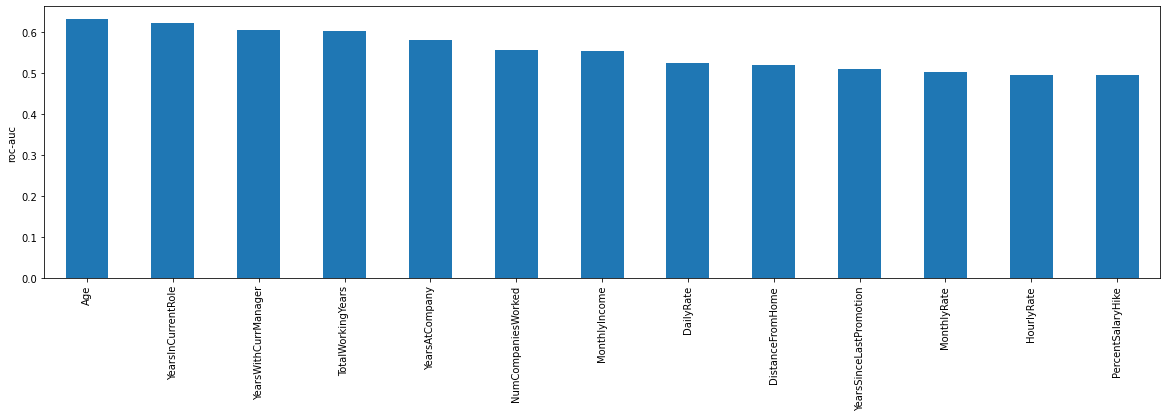

In [ ]:
roc_values = pd.Series(roc_values)
roc_values.index = num_feats
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 5))
plt.ylabel('roc-auc')

In [ ]:
feat_w_high_roc_auc = roc_values[roc_values > 0.5].index
feat_w_high_roc_auc

Index(['Age', 'DailyRate', 'DistanceFromHome', 'MonthlyIncome', 'MonthlyRate',
       'NumCompaniesWorked', 'TotalWorkingYears', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')

# ENTRENAMIENTO Y EVALUACION DE MODELOS DE REGRESION LOGISTICA.

## Declaracion y entrenamiento del modelo de regresion logistica.

In [ ]:
def model_performance(classifier, X_train, X_test, y_train, y_test):
  classifier.fit(X_train, y_train)

  pred = classifier.predict(X_train)

  print("Train set")

  print(f"{classifier} roc-auc: {roc_auc_score(y_train, pred)}")

  pred = classifier.predict(X_test)
  
  print("Test set")

  print(f"{classifier} roc-auc: {roc_auc_score(y_test, pred)}")

  print(f"Acurracy {100*accuracy_score(y_test, pred)}")

  print("-------------------------")
  print((classification_report(y_test, pred)))

  cm = confusion_matrix(y_test, pred)
  sns.heatmap(cm, annot=True)

**ESCALADO DE DATOS**

In [ ]:
# concatenamos los features ya analizados
features = feat_w_high_roc_auc.tolist() + feat_w_high_depAttrition.tolist()
features

['Age',
 'DailyRate',
 'DistanceFromHome',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'TotalWorkingYears',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'BusinessTravel',
 'Department',
 'EducationField',
 'JobRole',
 'MaritalStatus',
 'OverTime',
 'EnvironmentSatisfaction',
 'JobInvolvement',
 'JobLevel',
 'JobSatisfaction',
 'StockOptionLevel',
 'WorkLifeBalance']

In [ ]:
# dropeamos los features que estan altamente corr (calculados anteriormente)
features.remove("YearsAtCompany")
features.remove("JobLevel")

# escalamos los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_RE[features])
X_test_scaled = scaler.transform(X_test_RE[features])

**RANDOM FOREST**

Train set
RandomForestClassifier(max_depth=14, max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=5, n_estimators=200, random_state=92) roc-auc: 0.8263473053892216
Test set
RandomForestClassifier(max_depth=14, max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=5, n_estimators=200, random_state=92) roc-auc: 0.5986522911051213
Acurracy 87.07482993197279
-------------------------
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       371
           1       0.93      0.20      0.33        70

    accuracy                           0.87       441
   macro avg       0.90      0.60      0.63       441
weighted avg       0.88      0.87      0.83       441



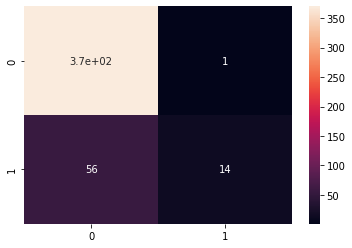

In [ ]:
rfc= RandomForestClassifier(max_depth=14, max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=5, n_estimators=200, random_state=92)

model_performance(rfc, X_train_scaled,X_test_scaled, y_train, y_test)

**LOGISTIC REGRESSION**

Train set
LogisticRegression(C=100, class_weight='balanced', random_state=0,
                   solver='liblinear') roc-auc: 0.7749524153549051
Test set
LogisticRegression(C=100, class_weight='balanced', random_state=0,
                   solver='liblinear') roc-auc: 0.7850404312668463
Acurracy 78.45804988662131
-------------------------
              precision    recall  f1-score   support

           0       0.95      0.78      0.86       371
           1       0.41      0.79      0.54        70

    accuracy                           0.78       441
   macro avg       0.68      0.79      0.70       441
weighted avg       0.86      0.78      0.81       441



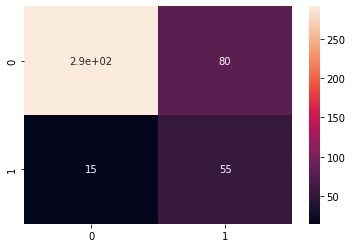

In [ ]:
lr = LogisticRegression(C=100, class_weight='balanced', random_state=0,
                        solver='liblinear')

model_performance(lr, X_train_scaled, X_test_scaled, y_train, y_test)

**Conclusion:**

A partir de los dos modelos entrenados podemos concluir que:

* **RandomForest** tiende a tener over-fitting (lo podemos ver a partir del roc-auc del train vs test set). Dicho modelo presenta una precision del 88% **PERO** posee un muy bajo porcentaje de recall en cto a los empleados que se marchan, ie que **NO es capaz de capturar el 70% de los empleados que abandonan la empresa**.

* **LogisticRegression** NO posee over-fitting. A su vez dicho modelo presenta una precision del 77% (menor al rfc), dicha precision se ve afectada, ya que el modelo a la hora de predecir los empleados que se marchan predice correctamente un 40% de ellos, **PERO** podemos ver que **la metrica de recall es bastante superior a la de rfc** llegando a casi un 80% ie que **el modelo es capaz de capturar el 80% de los empleados que se marchan** por ende a pesar de la precision parece ser mucho mejor modelo que el rfc para este particular problema.


**OBS:** El modelo a seleccionar dependera del riesgo que este dispuesto a tomar la empresa.

A su vez podemos ver que los features mas importantes a la hora de determinar si un empleado se queda o se marcha son:

* OverTime
* YearsSinceLastPromotion
* MonthlyIncome
* EnvironmentSatisfaction
* EducationField	

**OBS:**

Al principio del notebook pudimos apreciar que en el dataframe analizado solo un 16% correspondia a empleados que se marchaban de la empresa, por lo que dichos modelos podrian tener una mejor performance si el dataframe estuviera mas balanceado, ie si hubiera muchos mas datos de personas que abandonan la empresa.

In [ ]:
feature_importance = pd.DataFrame()
feature_importance["Feature"] = features
feature_importance["Coef"] = np.abs(lr.coef_.flatten())
feature_importance.sort_values(by="Coef", ascending=False).head()

,Feature,Coef
15,OverTime,0.688853
8,YearsSinceLastPromotion,0.516034
3,MonthlyIncome,0.437022
16,EnvironmentSatisfaction,0.428369
12,EducationField,0.425773
